In [1]:
from Archivos_Apoyo.AngleCouplingAnalyzer import AngleCouplingAnalyzer
ruta_entrenamiento_robot="logs_lift_leg/general_values_20251012_142622.pid15824.csv"
ruta_recompensas="logs_lift_leg/rewards_20251012_142622.pid15824.csv"
anglecouplinganalyzer=AngleCouplingAnalyzer()

In [2]:
df_general=anglecouplinganalyzer.cargar_csv(ruta_entrenamiento_robot)
df_recompensas=anglecouplinganalyzer.cargar_csv(ruta_recompensas)

In [3]:
angulos_joints=anglecouplinganalyzer.split_parameters_df(df_general, startswith="q_")
angular_speed=anglecouplinganalyzer.split_parameters_df(df_general, startswith="vel_")
torque=anglecouplinganalyzer.split_parameters_df(df_general, startswith="τ_reaction_")
forces=anglecouplinganalyzer.split_parameters_df(df_general, startswith="Forces_")
pressures=anglecouplinganalyzer.split_parameters_df(df_general, startswith="Pressure_")
coms=anglecouplinganalyzer.split_parameters_df(df_general, startswith="COM_")
zmps=anglecouplinganalyzer.split_parameters_df(df_general, startswith="ZMP_")
df_angle_speed = df_general.loc[:, df_general.columns.str.startswith(("q_", "vel_"))]
df_angle_com = df_general.loc[:, df_general.columns.str.startswith(("q_left_hip", "q_right_hip", "COM_"))]
df_presiones_velocidades=df_general.loc[:, df_general.columns.str.startswith(("vel_", "Pressure_"))]

In [4]:
df_presiones_velocidades

,vel_left_hip_pitch_joint,Pressure_left_hip_pitch_jointflexion,Pressure_left_hip_pitch_jointextension,vel_left_hip_roll_joint,Pressure_left_hip_roll_jointflexion,Pressure_left_hip_roll_jointextension,vel_left_knee_joint,Pressure_left_knee_jointflexion,Pressure_left_knee_jointextension,vel_left_ankle_pitch_joint,...,Pressure_right_hip_roll_jointextension,vel_right_knee_joint,Pressure_right_knee_jointflexion,Pressure_right_knee_jointextension,vel_right_ankle_pitch_joint,Pressure_right_ankle_pitch_jointflexion,Pressure_right_ankle_pitch_jointextension,vel_right_ankle_roll_joint,Pressure_right_ankle_roll_jointflexion,Pressure_right_ankle_roll_jointextension
0,0.040,0.091474,0.0,0.013,0.000000,0.144176,-0.044,0.040356,0.031235,0.072,...,0.000000,0.000,0.083071,0.000000,0.051,0.000000,0.000000,-0.030,0.0,0.056994
1,-3.119,0.010001,0.0,0.422,0.000000,0.185497,2.912,0.000000,0.042935,-1.333,...,0.000000,-0.000,0.166422,0.140415,0.259,0.000000,0.020964,-0.059,0.0,0.092617
2,-2.604,0.001729,0.0,0.993,0.000000,0.205851,3.241,0.000000,0.074776,-1.530,...,0.000000,-0.000,0.186402,0.199227,0.248,0.000000,0.000000,-0.006,0.0,0.073438
3,-1.596,0.015703,0.0,1.485,0.000000,0.206064,3.172,0.000000,0.094888,-1.693,...,0.000000,-0.000,0.147169,0.197087,0.177,0.000000,0.000000,0.147,0.0,0.047408
4,1.851,0.141801,0.0,-0.421,0.000000,0.142227,1.368,0.048952,0.005449,0.000,...,0.000000,0.000,0.000000,0.022197,-0.009,0.000000,0.041848,0.644,0.0,0.068457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14235,1.084,0.438143,0.0,-0.044,0.000000,0.324927,0.013,0.000000,0.500907,-0.279,...,0.000000,0.019,0.060479,0.130660,-0.356,0.000000,0.000000,1.529,1.0,0.000000
14236,0.209,0.634381,0.0,0.001,0.000000,0.000000,0.008,0.000000,0.000000,-0.006,...,0.000000,0.028,0.000000,0.000000,0.369,0.000000,1.000000,-1.231,0.0,0.000000
14237,0.782,0.821371,0.0,-0.000,0.000000,0.042131,0.000,0.000000,0.000000,-0.030,...,0.000000,-0.371,0.221949,0.000000,1.134,0.076299,0.000000,1.262,1.0,0.000000
14238,-0.072,0.353758,0.0,-0.106,0.096065,0.000000,0.056,0.000000,0.505901,-0.291,...,0.000000,-0.006,0.000000,0.473423,-0.405,0.562827,0.000000,1.439,1.0,0.000000


In [5]:
corr_angulos = anglecouplinganalyzer.correlacion_entre_params(angulos_joints)
corr_angular_speed = anglecouplinganalyzer.correlacion_entre_params(angular_speed)
corr_torque = anglecouplinganalyzer.correlacion_entre_params(torque)
corr_forces = anglecouplinganalyzer.correlacion_entre_params(forces)
corr_presiones=anglecouplinganalyzer.correlacion_entre_params(pressures)
corr_recompensas=anglecouplinganalyzer.correlacion_entre_params(df_recompensas.iloc[:,3:])
corr_coms=anglecouplinganalyzer.correlacion_entre_params(coms)
corr_zmp=anglecouplinganalyzer.correlacion_entre_params(zmps)

In [6]:
corr_angulo_velocidad=anglecouplinganalyzer.correlacion_entre_params(df_angle_speed)
corr_velocidad_presiones=anglecouplinganalyzer.correlacion_entre_params(df_presiones_velocidades)
corr_com_angulo=anglecouplinganalyzer.correlacion_entre_params(df_angle_com)

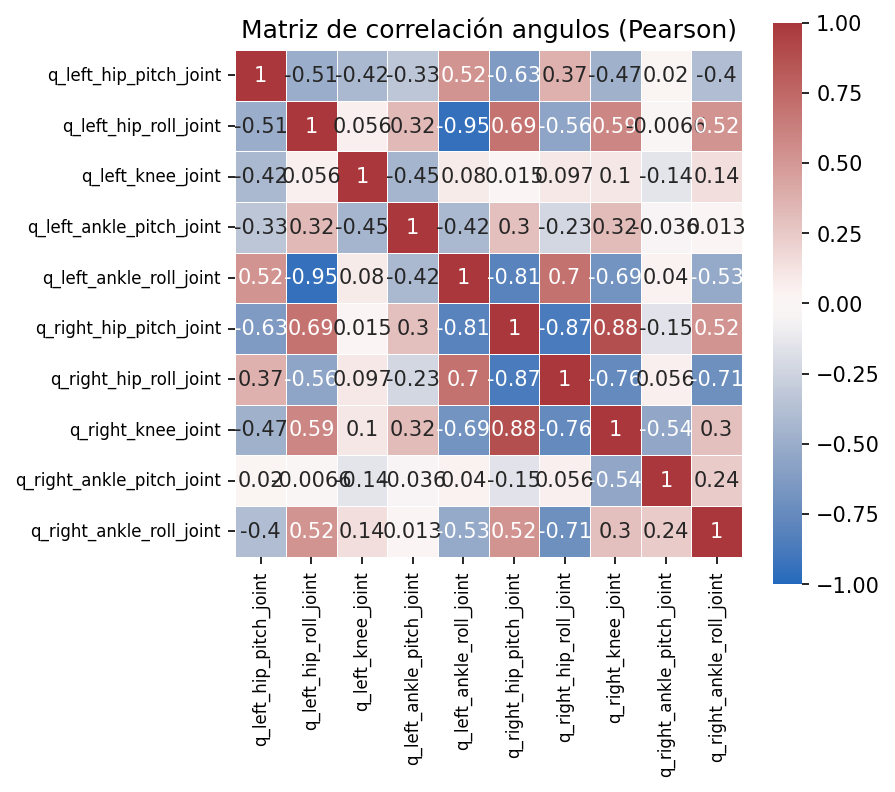

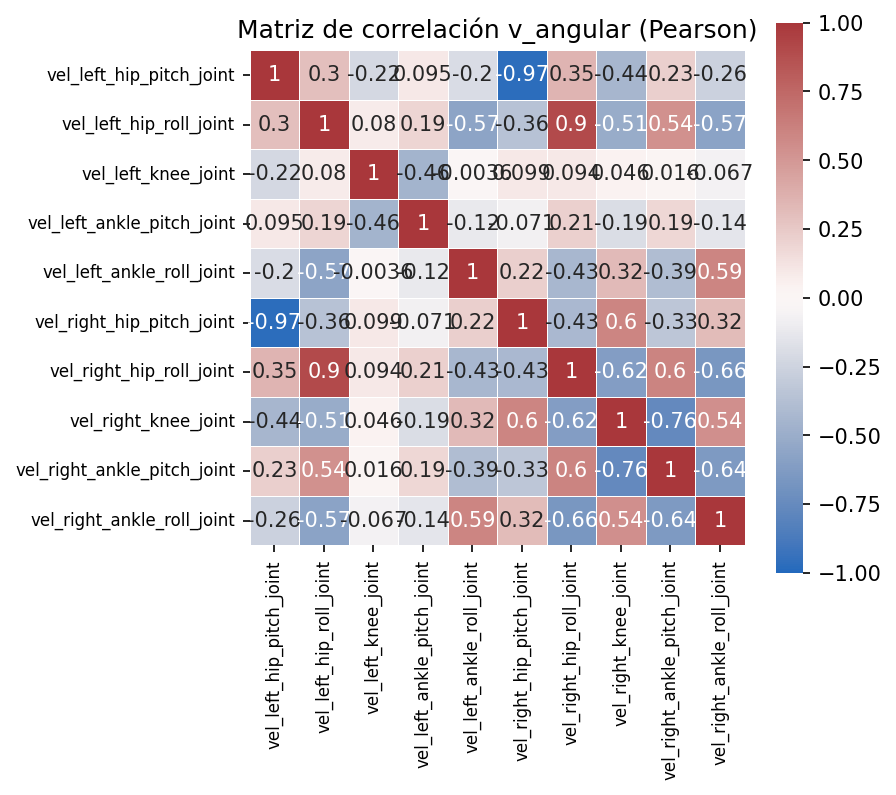

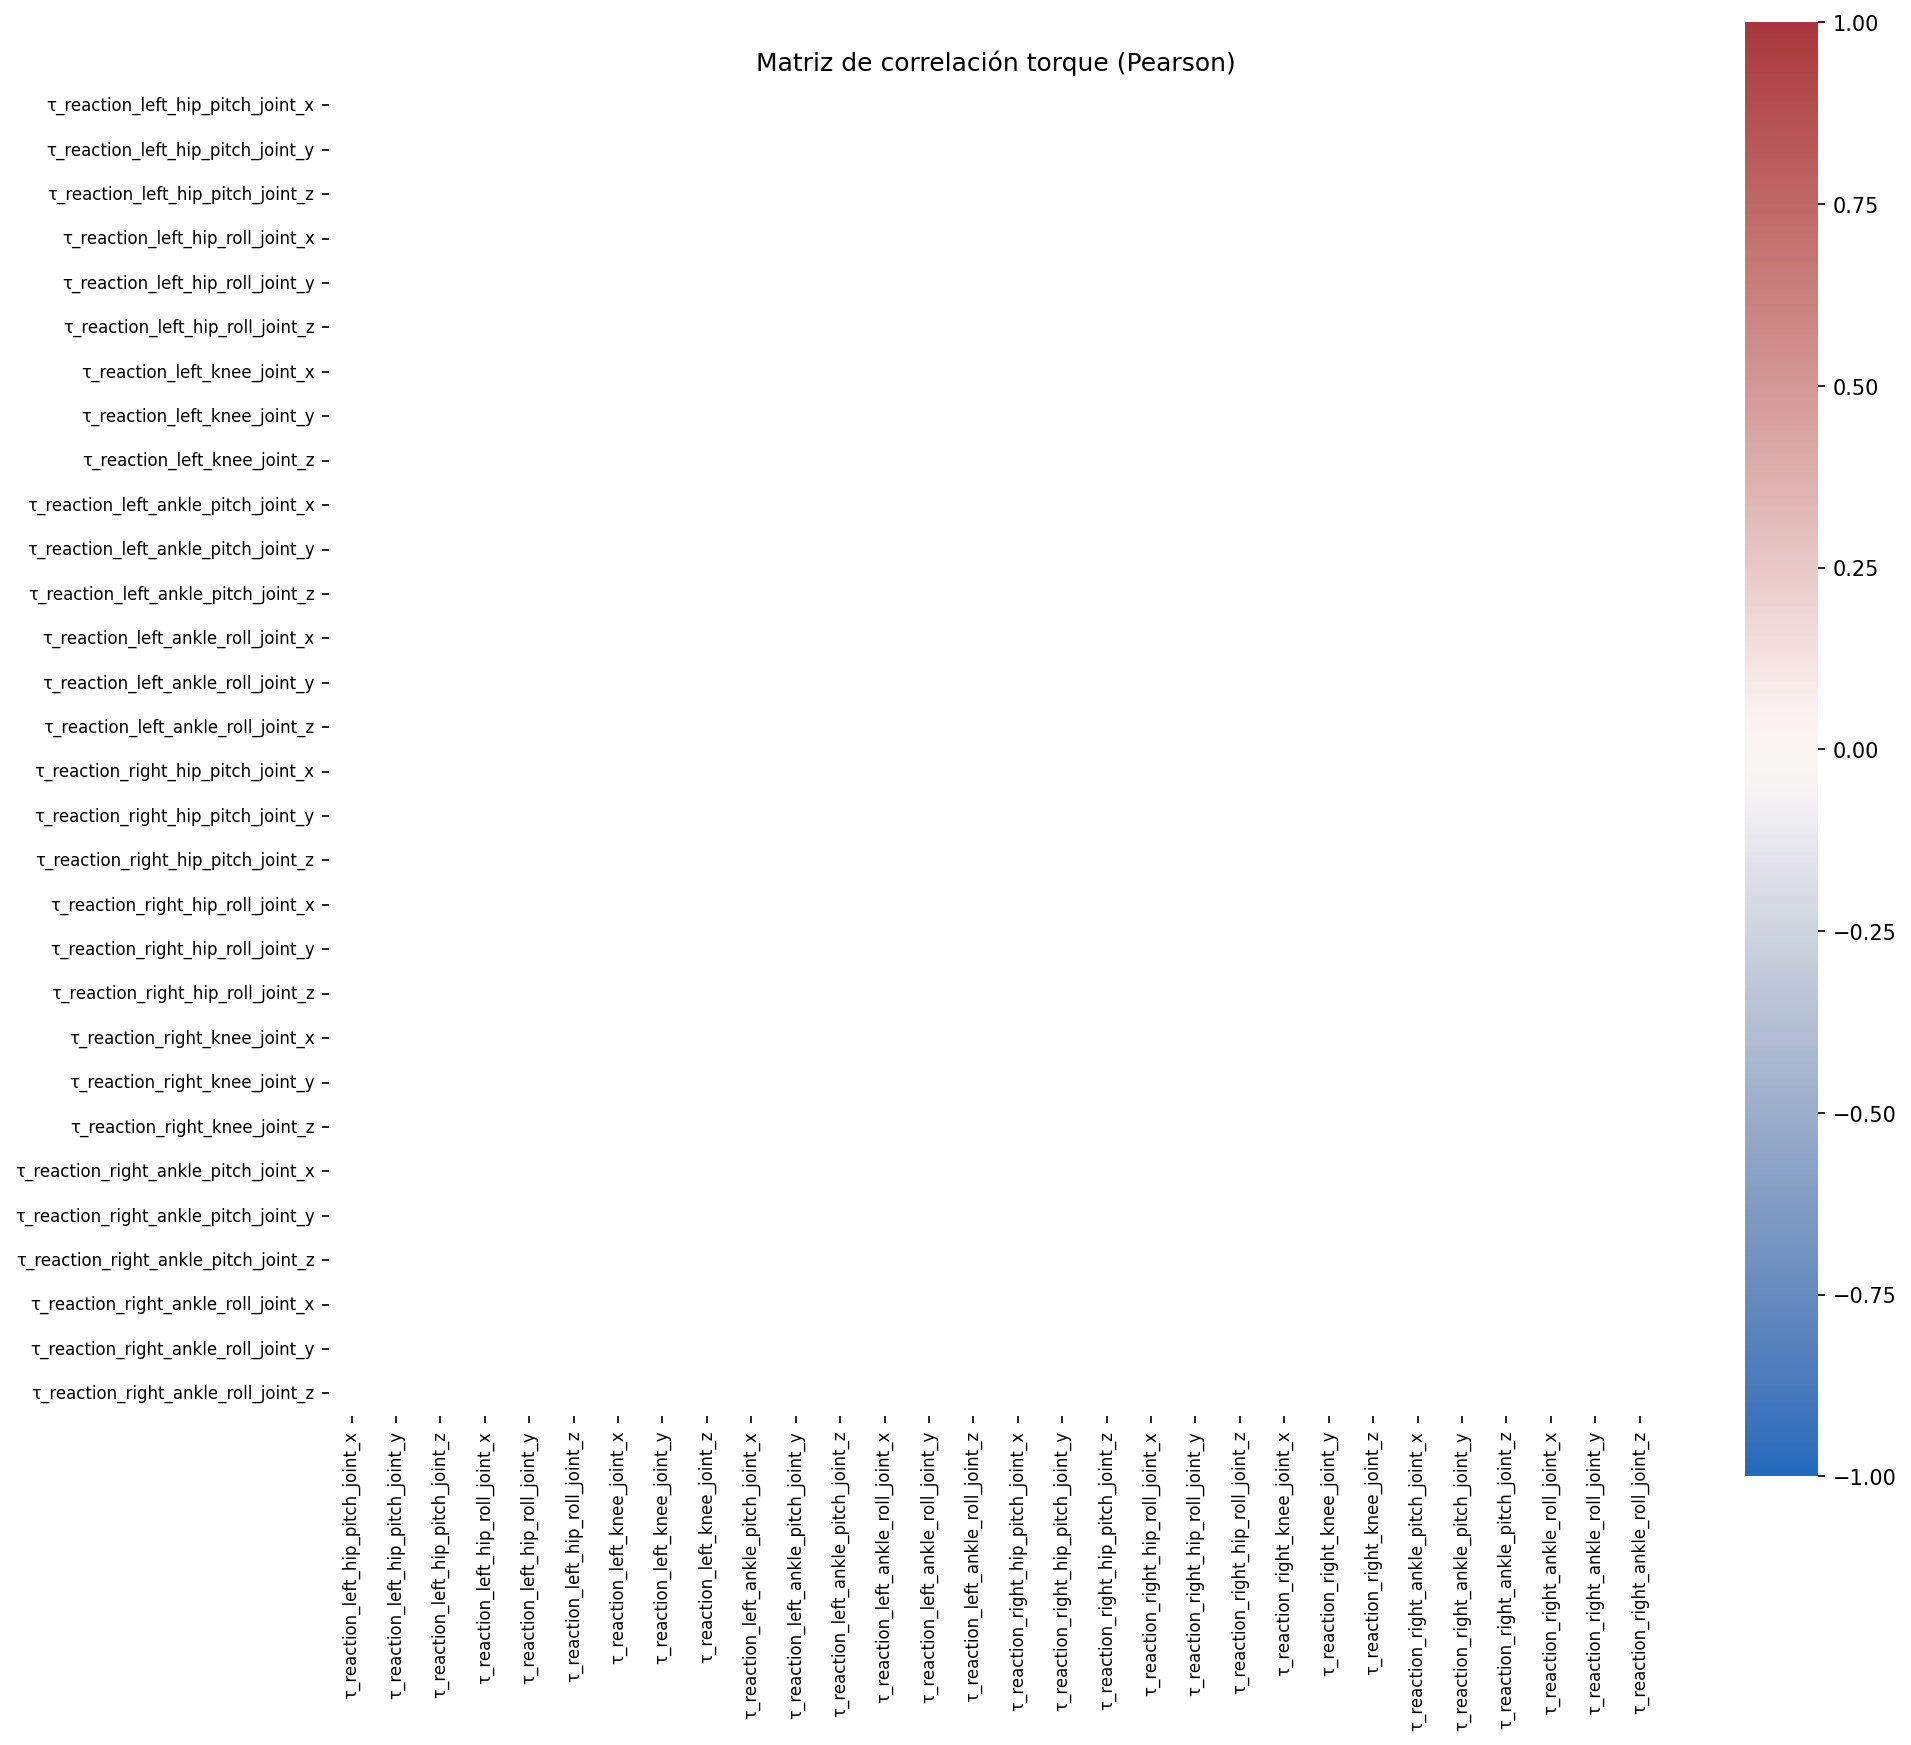

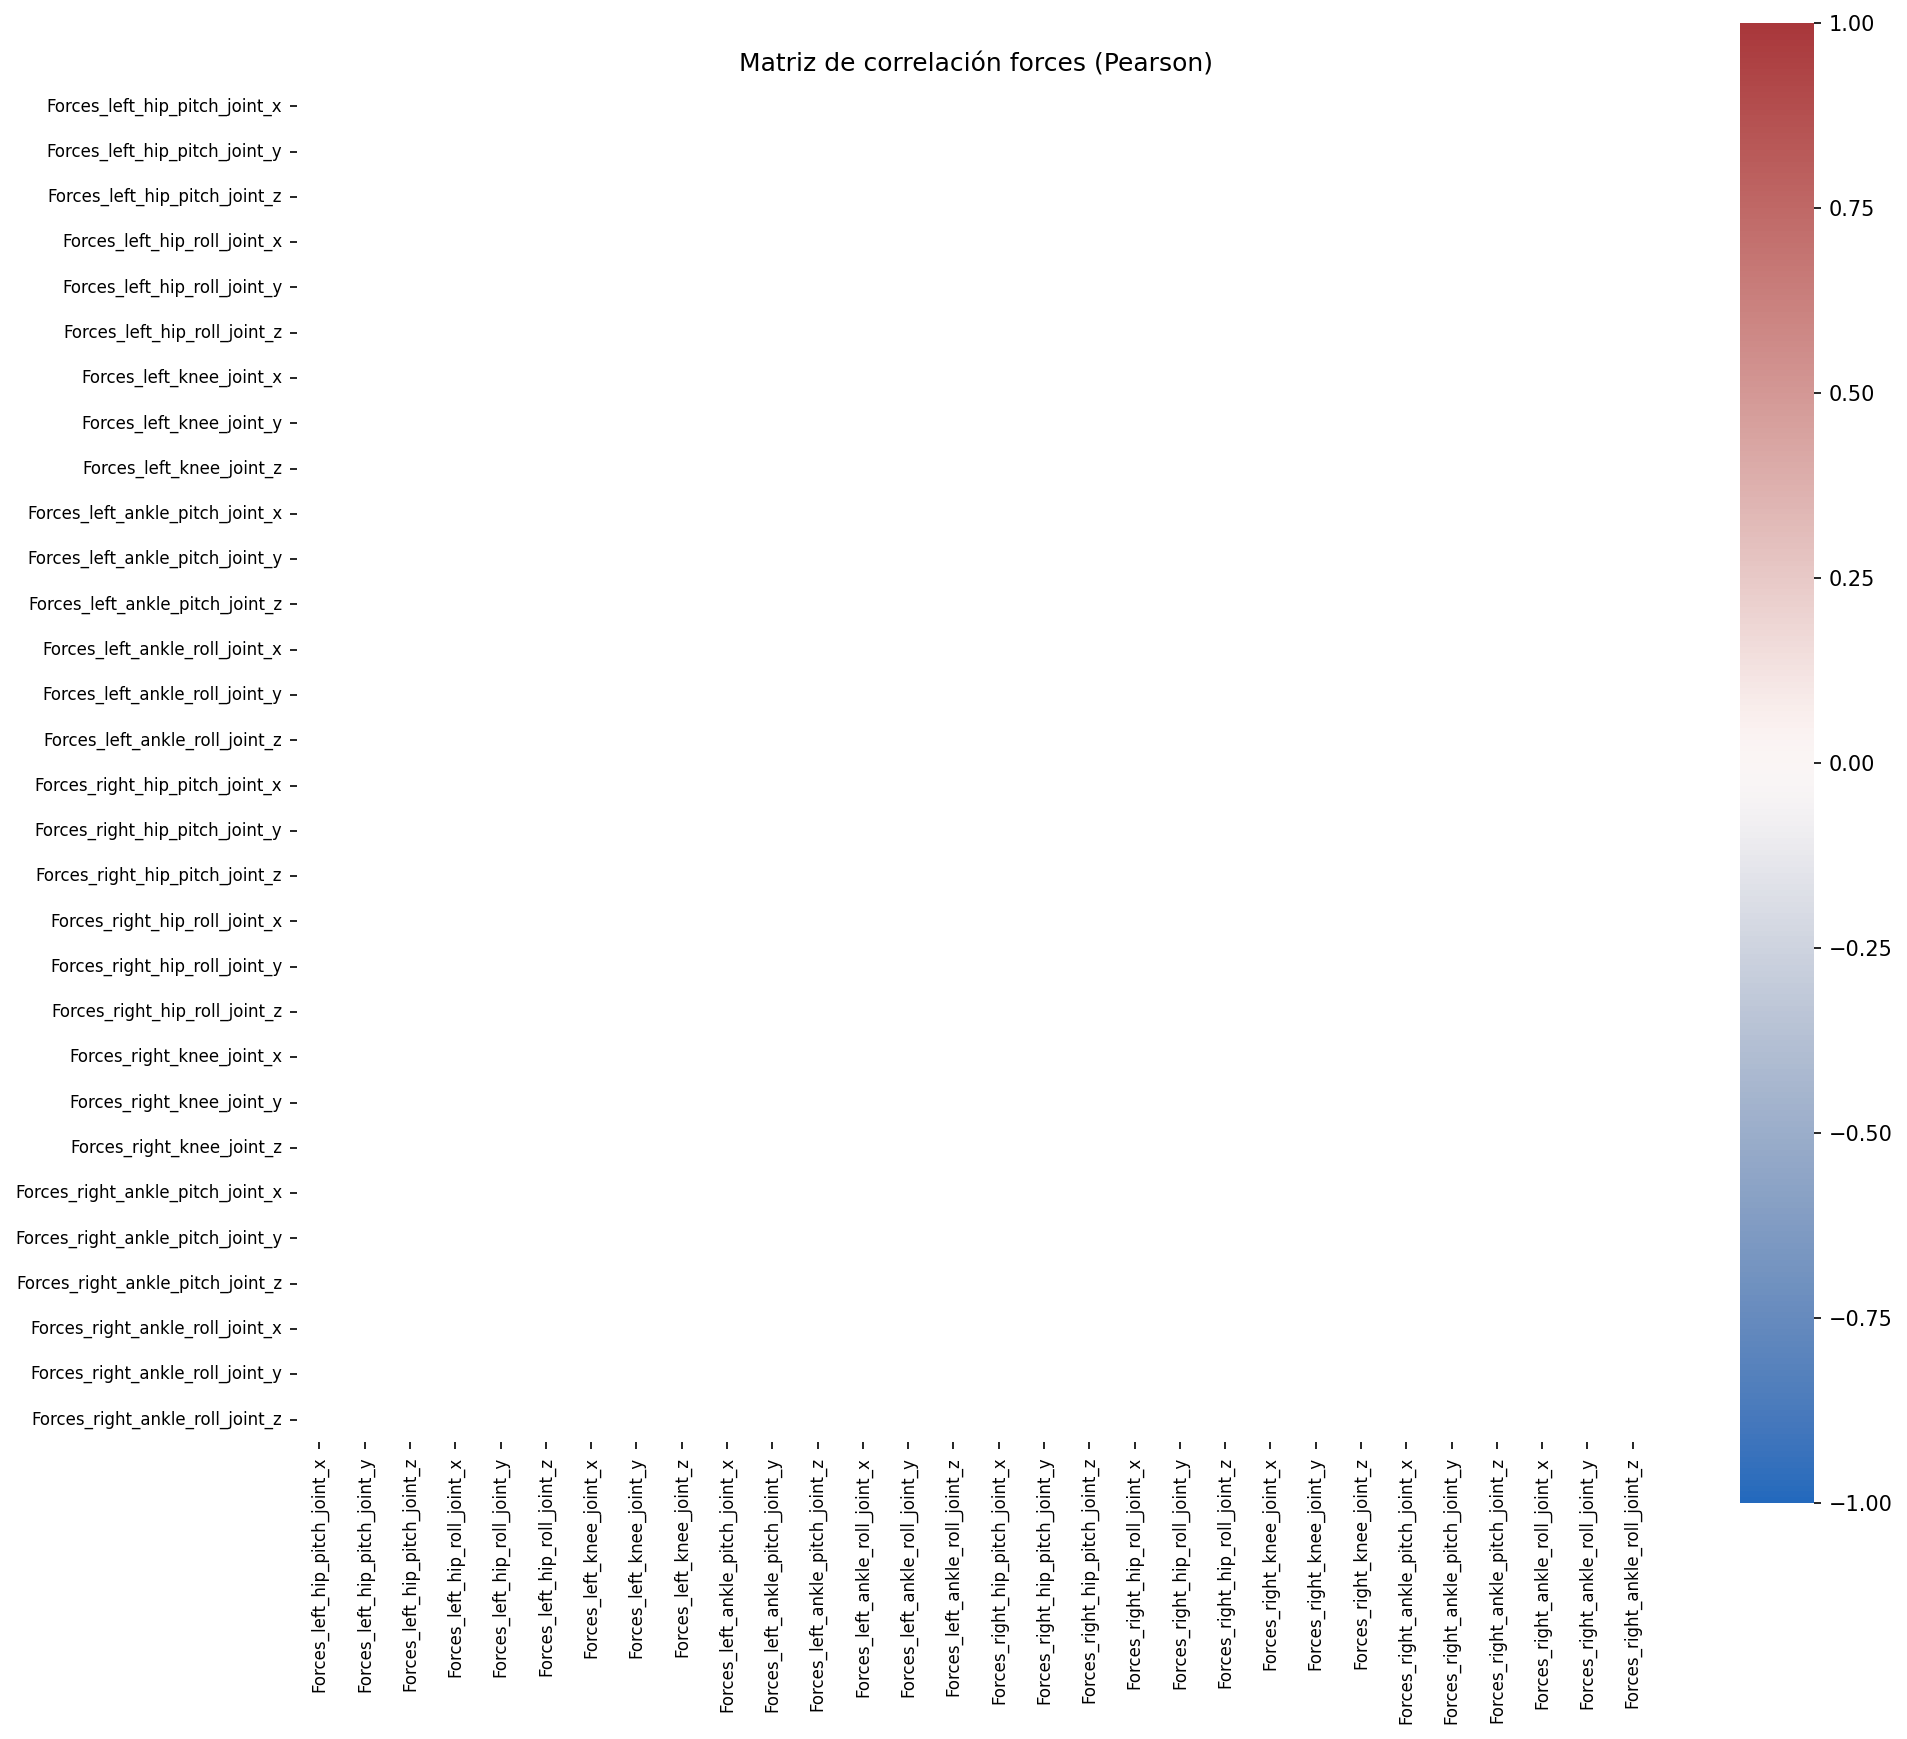

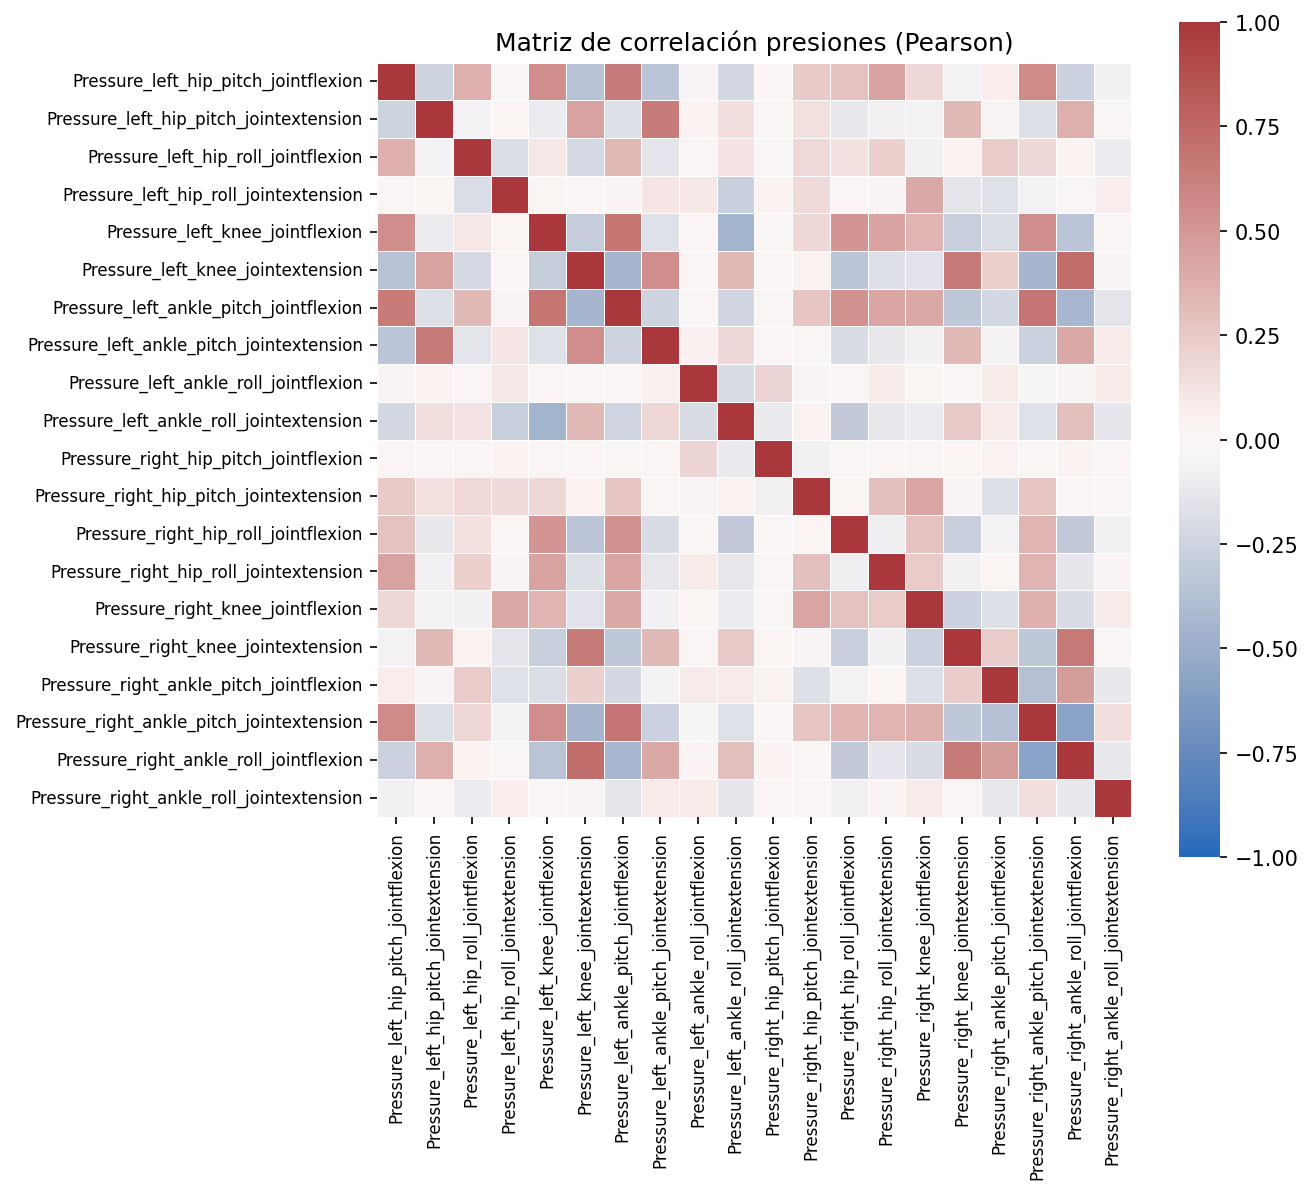

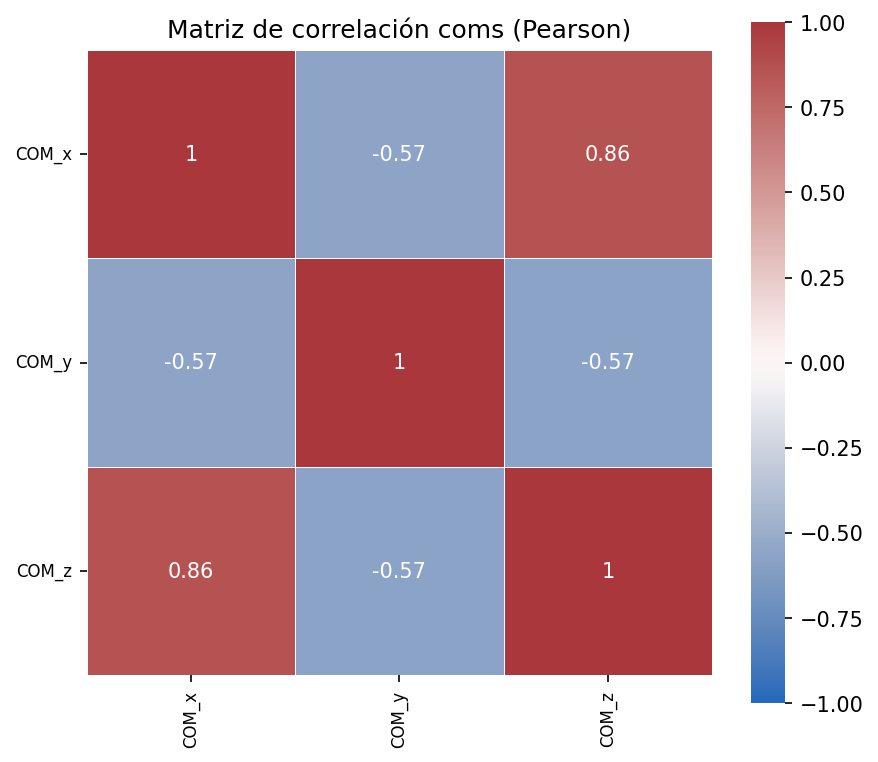

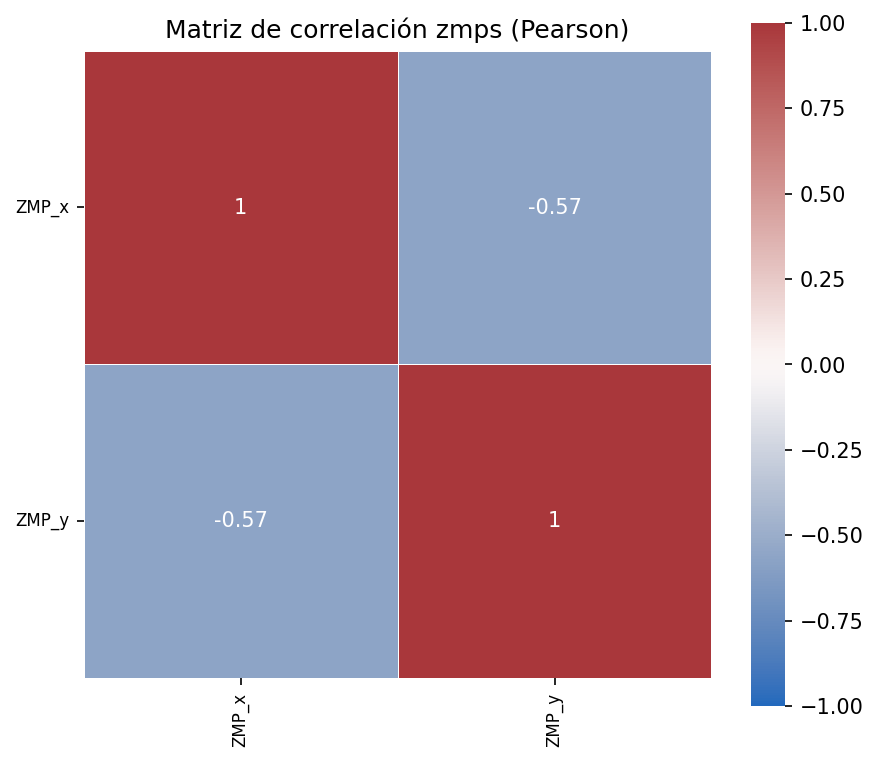

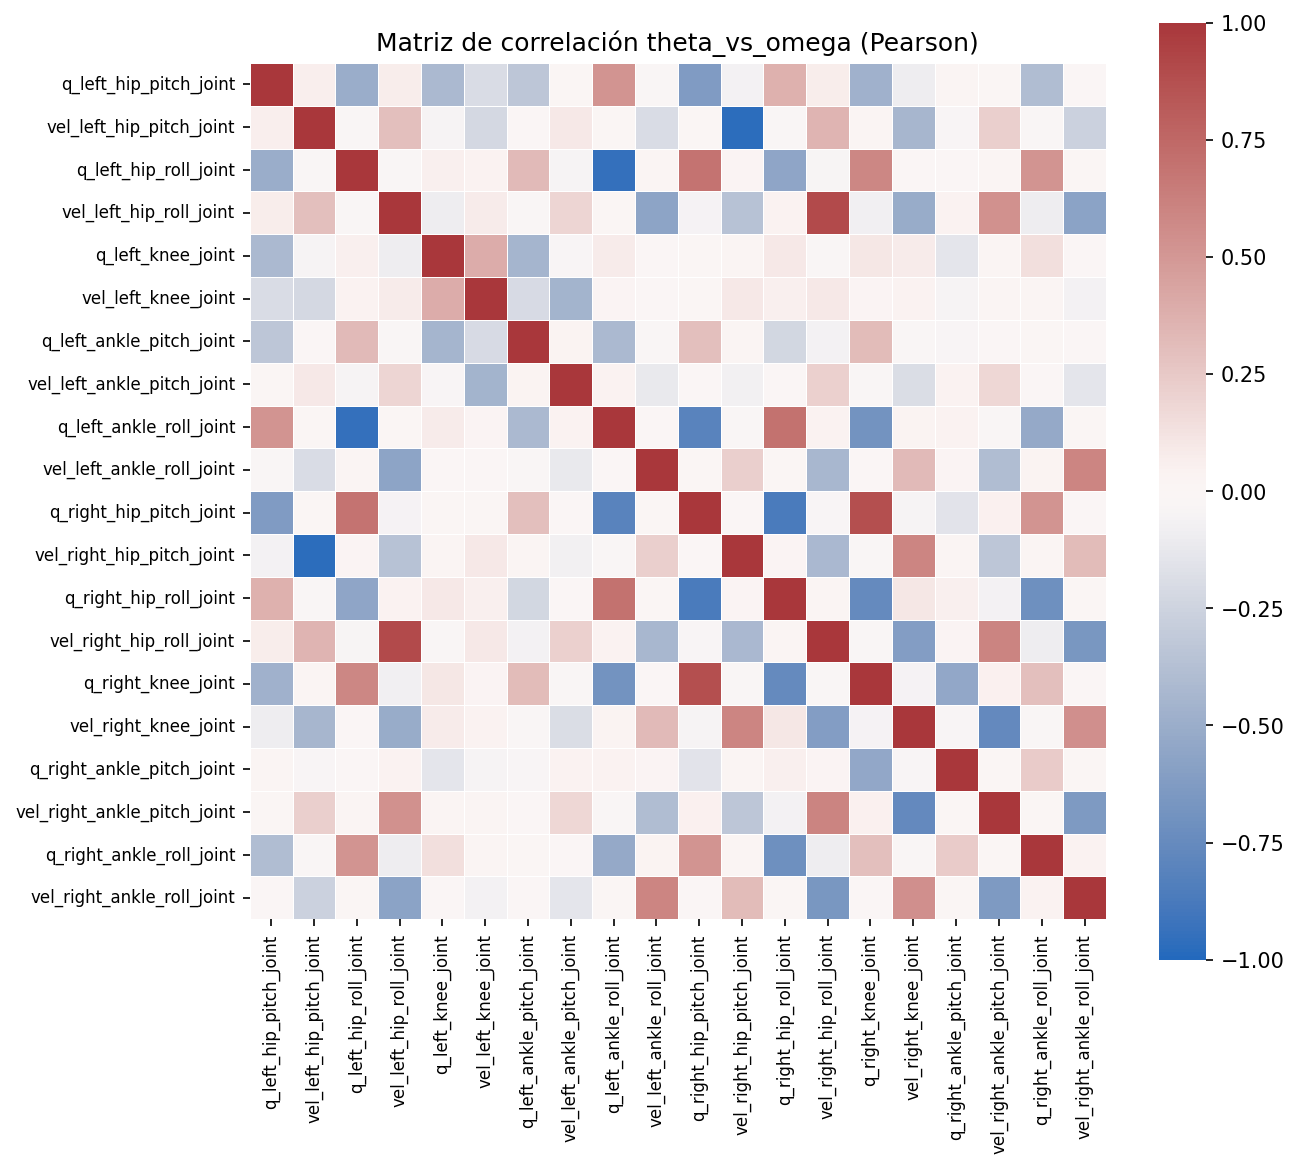

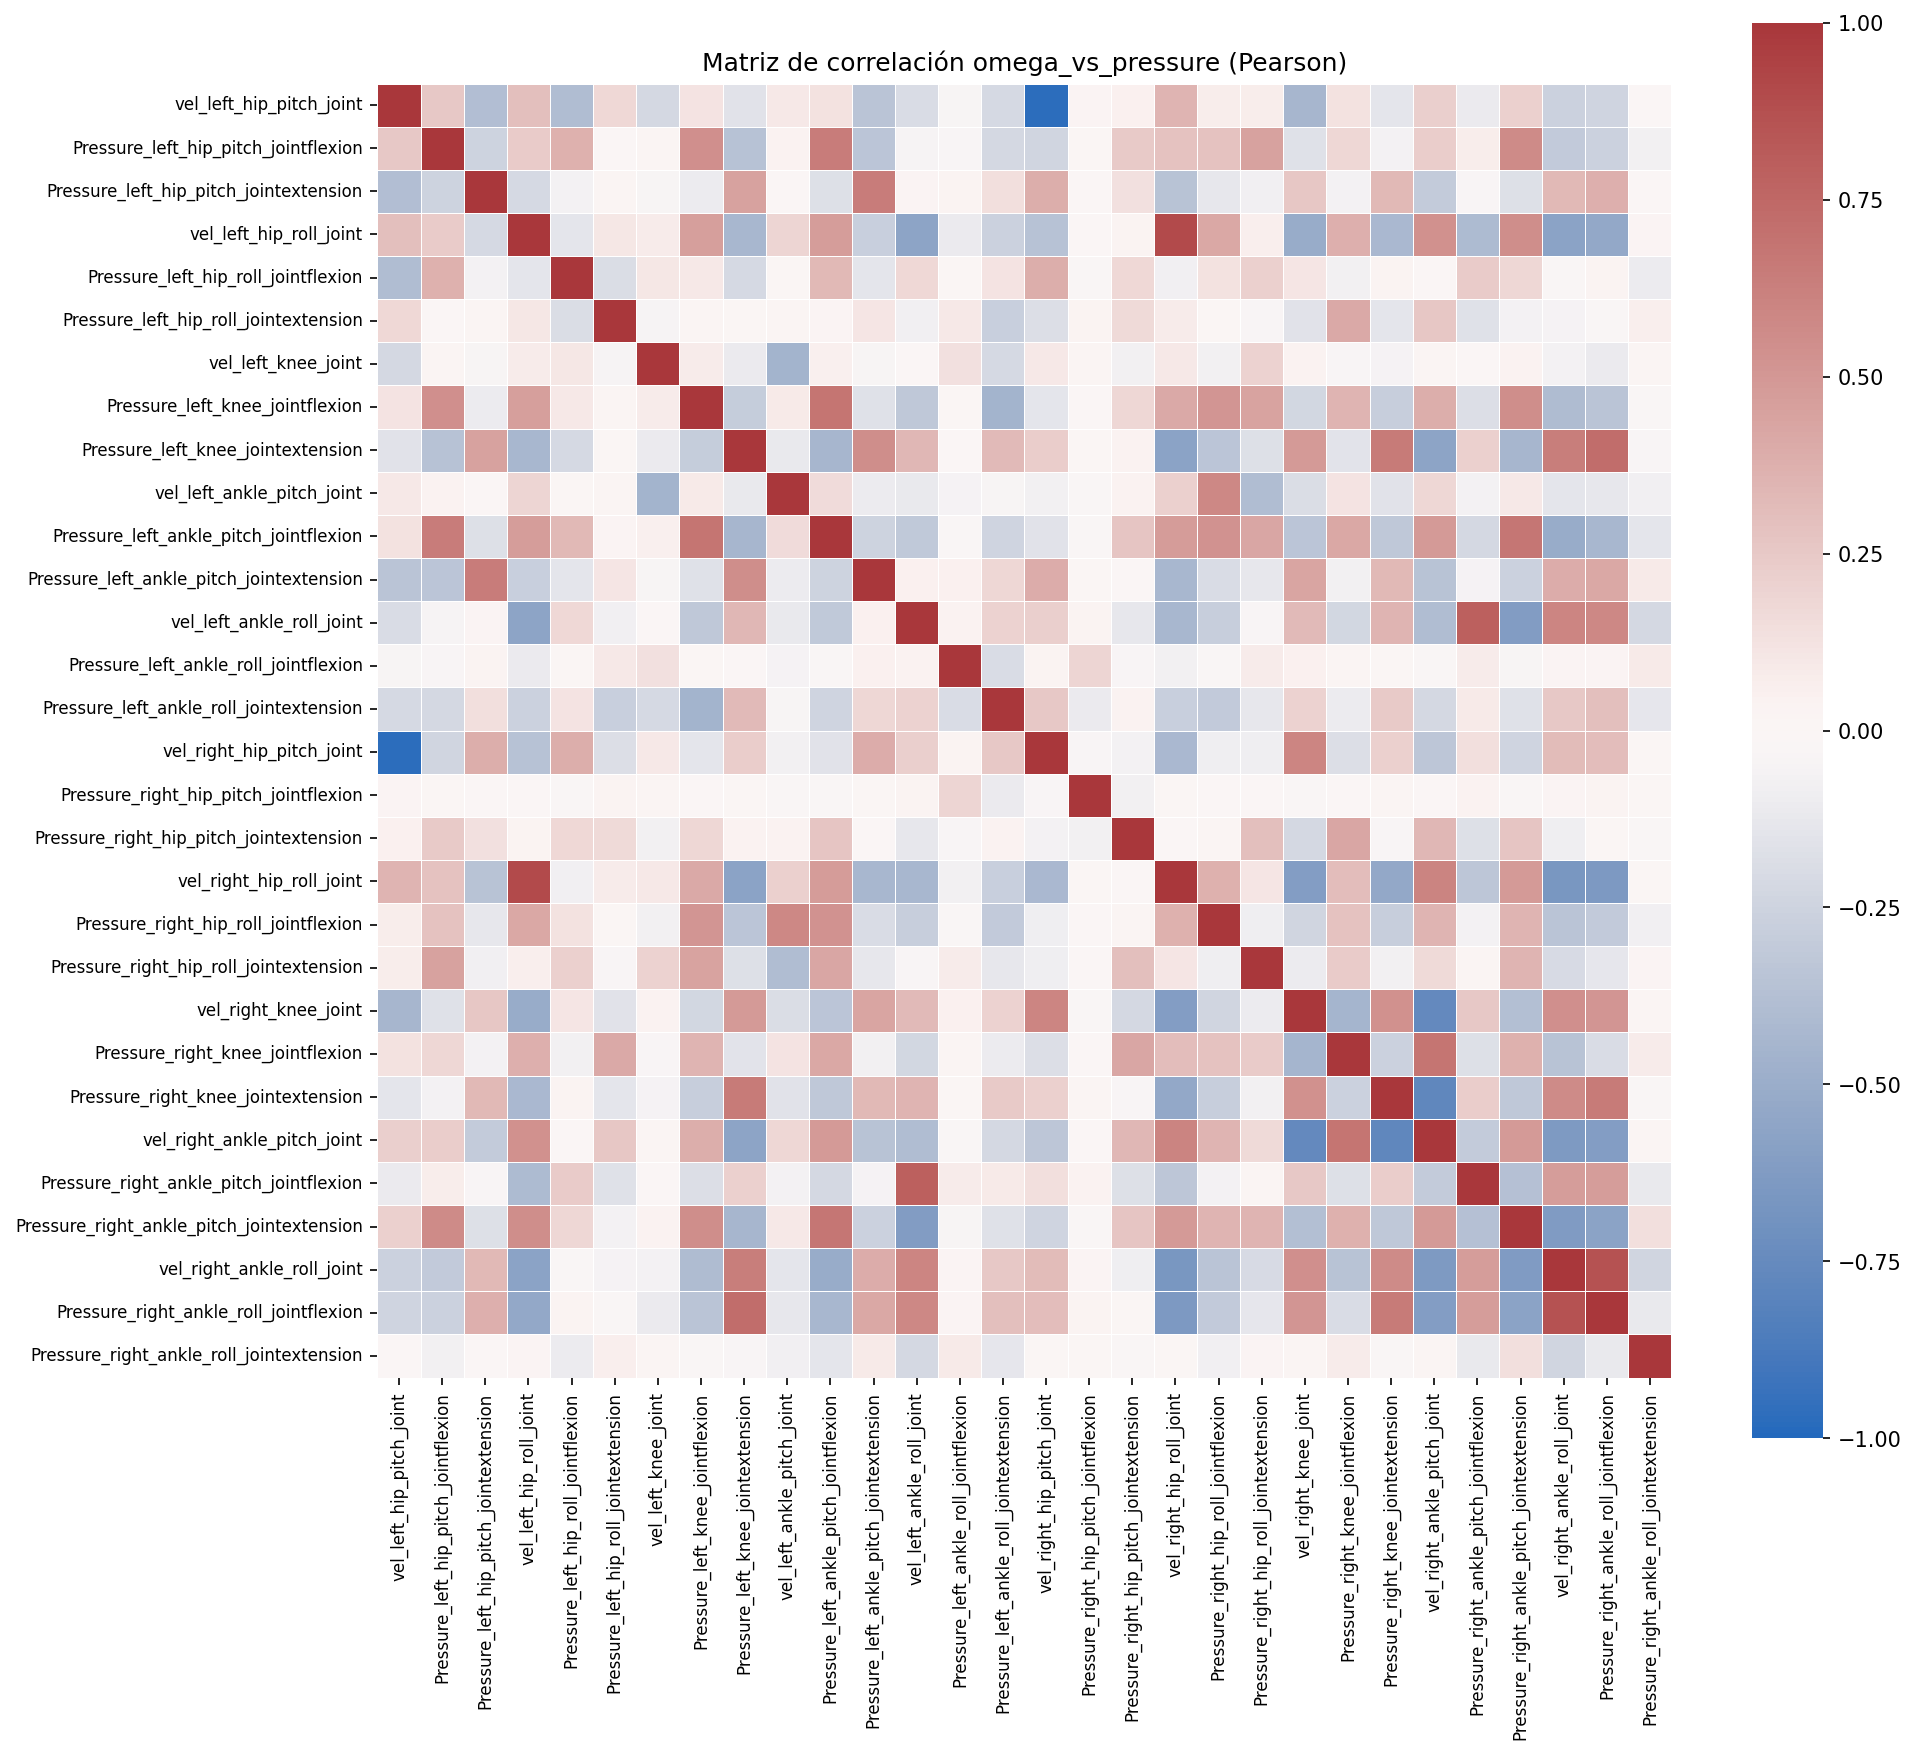

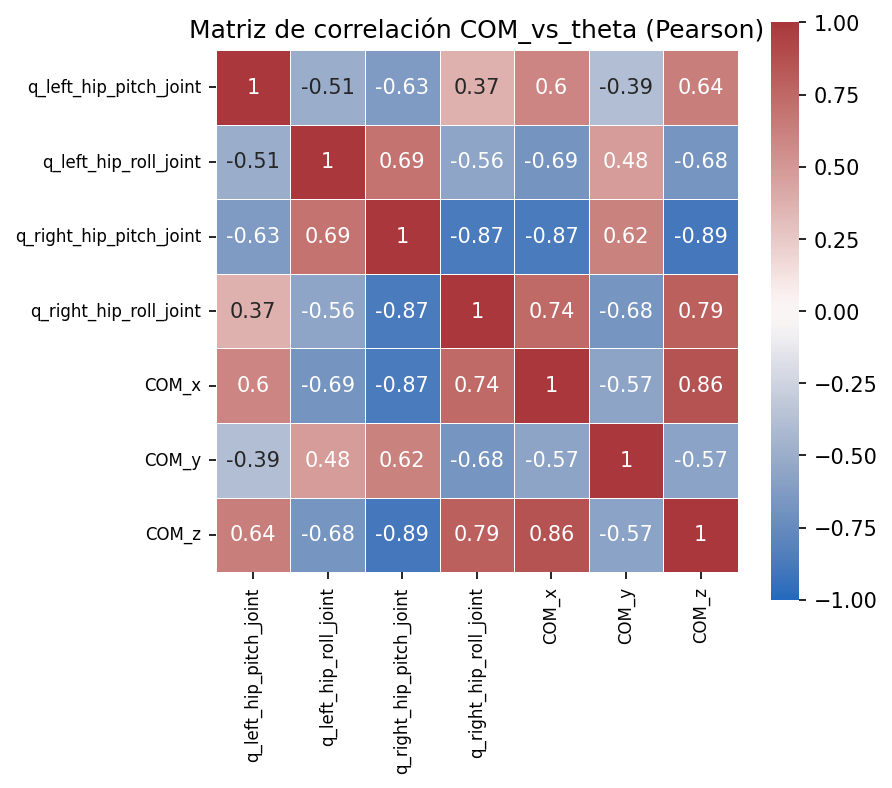

In [7]:
anglecouplinganalyzer.creacion_correlaciones(corr_angulos,"angulos")
anglecouplinganalyzer.creacion_correlaciones(corr_angular_speed, "v_angular")
anglecouplinganalyzer.creacion_correlaciones(corr_torque,"torque", annot=False)
anglecouplinganalyzer.creacion_correlaciones(corr_forces, "forces", annot=False)
anglecouplinganalyzer.creacion_correlaciones(corr_presiones, "presiones", annot=False)
#anglecouplinganalyzer.creacion_correlaciones(corr_recompensas, "recompensas", annot=False)
anglecouplinganalyzer.creacion_correlaciones(corr_coms, "coms")
anglecouplinganalyzer.creacion_correlaciones(corr_zmp, "zmps")
anglecouplinganalyzer.creacion_correlaciones(corr_angulo_velocidad, "theta_vs_omega", annot=False)
anglecouplinganalyzer.creacion_correlaciones(corr_velocidad_presiones, "omega_vs_pressure", annot=False)
anglecouplinganalyzer.creacion_correlaciones(corr_com_angulo, "COM_vs_theta")